<a href="https://colab.research.google.com/github/ander-elkoroaristizabal/Glaucoma-detection-w-CNNs/blob/main/DL_PRA_AnderElkoaroaristizabal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PRA</p>
<p style="margin: 0; text-align:right;">2021-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# Práctica: CNNs for automatic glaucoma assessment

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image

In [ ]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam, SGD, Adadelta, Adagrad
from sklearn.metrics import confusion_matrix, classification_report

Fijamos las semillas aleatorias de `numpy` y de `tensorflow` para garantizar la reproducibilidad de los resultados:

In [ ]:
import tensorflow.random as tf_random
np.random.seed(1)
tf_random.set_seed(1)

Obtenemos la fecha, que determinará el nombre con el que se guardarán los modelos:

In [ ]:
from datetime import datetime

In [ ]:
date = datetime.today().strftime('%Y-%m-%d')

Fijamos las variables de settings:

In [ ]:
data_dir = "Data"
models_dir = "Models"
images_shape = (224, 224, 3)

In [ ]:
# Diccionario con los labels:
label2value = {
    'normal': 0, 
    'abnormal': 1
}
value2label = {
    0: 'normal', 
    1: 'abnormal'
}

## 1. Descarga y análisis exploratorio de los datos (1,5 puntos)

### 1.1 Descarga de datos
Empezamos importando los datos:

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# añade el path a tu directorio
%cd ./drive/MyDrive/Practica_DL

/content/drive/MyDrive/Practica_DL


In [ ]:
from os import walk, path

In [ ]:
def read_glaucoma_fold_dataset(fold):
  base_path = path.join(data_dir, fold)
  feature_label_tuples = []
  for subset in ('train', 'valid', 'test'):
    X = []
    y = []
    for label in ('normal', 'abnormal'):
      subset_path = path.join(base_path, subset, label)
      (dirpath, dirnames, filenames) = next(walk(subset_path))
      label_value = label2value[label]
      for image_name in filenames:
        image_data = image.imread(subset_path + "/" + image_name)
        X.append(image_data)
        y.append(label_value)
    feature_label_tuples.append((np.array(X), np.array(y)))
  return feature_label_tuples

In [ ]:
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = read_glaucoma_fold_dataset("Fold0")

### 1.2 Análisis de los datos

A continuación mostramos la dimensión de los diferentes conjuntos de datos con los que trabajaremos:

In [ ]:
# Dimensiones de los datos:
print(f"La dimensión del conjunto de features de entrenamiento es {X_train.shape}.")
print(f"La dimensión del conjunto de labels de entrenamiento es {y_train.shape}.")
print(f"La proporción de casos abnormales es {round(y_train.mean(), 2)}.")

La dimensión del conjunto de features de entrenamiento es (1379, 224, 224, 3).
La dimensión del conjunto de labels de entrenamiento es (1379,).
La proporción de casos abnormales es 0.45.


In [ ]:
print(f"La dimensión del conjunto de features de validación es {X_valid.shape}.")
print(f"La dimensión del conjunto de labels de validación es {y_valid.shape}.")
print(f"La proporción de casos abnormales en la validación es {round(y_valid.mean(), 2)}.")

La dimensión del conjunto de features de validación es (154, 224, 224, 3).
La dimensión del conjunto de labels de validación es (154,).
La proporción de casos abnormales en la validación es 0.46.


In [ ]:
print(f"La dimensión del conjunto de features de evaluación es {X_test.shape}.")
print(f"La dimensión del conjunto de labels de evaluación es {y_test.shape}.")
print(f"La proporción de casos abnormales en el evaluación es {round(y_test.mean(), 2)}.")

La dimensión del conjunto de features de evaluación es (174, 224, 224, 3).
La dimensión del conjunto de labels de evaluación es (174,).
La proporción de casos abnormales en el evaluación es 0.53.


Las primeras y últimas 5 imágenes del conjunto de entrenamiento son las siguientes:

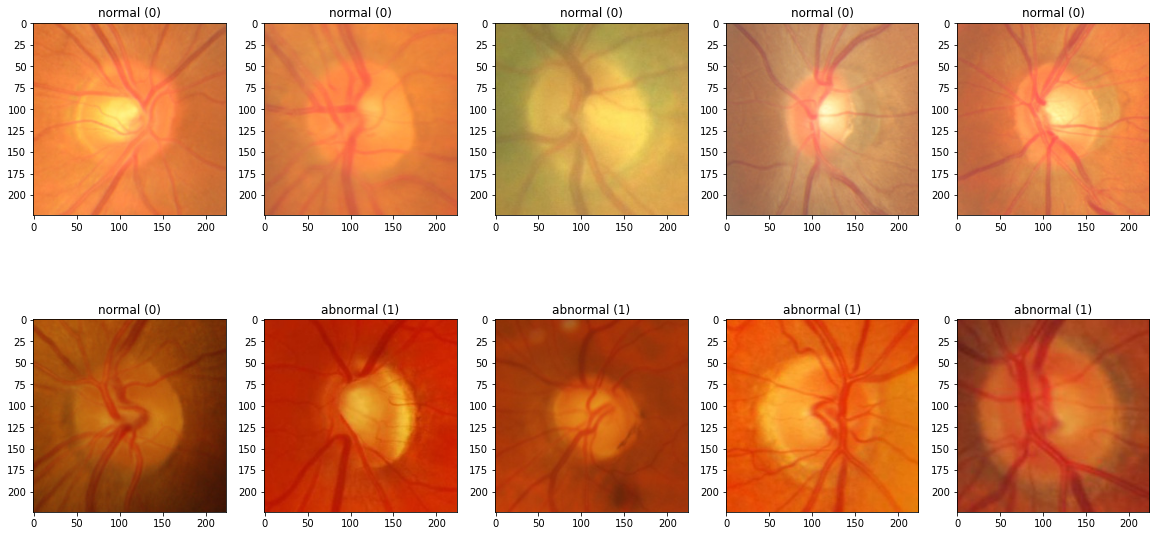

In [ ]:
# Creamos el subplot:
image, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
for i, ax in enumerate(axes.flat):
  # Resize de cada imagen:
  image = X_train[5-i]
  # Mostramos la imagen:
  ax.imshow(image)
  # Añadimos la etiqueta:
  y = y_train[5-i]
  ax.set_title(f"{value2label[y]} ({y})")
plt.show()

## 2. Entrenamiento de una red neuronal sobre una única partición [4 puntos]

### 2.1 Modelos basados en la EfficientNet B0

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
def efficientnet_transfer_model():
  # We get the Efficient Net:
  base_model = EfficientNetB0(
    include_top=False, # Do not include the ImageNet classifier at the top.
    weights="imagenet", # Load weights pre-trained on ImageNet.
    input_shape=images_shape # Shape of the data
  )
  # We set the Efficient Net to not trainable:
  base_model.trainable = False
  # We add the new layers on top:
  inputs = keras.Input(shape=images_shape)
  new_layers = base_model(inputs, training=False)
  new_layers = GlobalAveragePooling2D()(base_model.output)
  new_layers = BatchNormalization()(new_layers)
  new_layers = Dropout(0.2)(new_layers)
  outputs = Dense(1, activation='sigmoid')(new_layers)
  model = Model(inputs=base_model.inputs, outputs=outputs)
  return model

In [ ]:
def make_n_layers_trainable(model, n_layers):
  for layer in model.layers[(-n_layers):]:
    if isinstance(layer, BatchNormalization):
      continue
    else:
      layer.trainable = True

### Modelo 1

In [ ]:
model_1 = efficientnet_transfer_model()

Compilamos el modelo con la función de pérdida *binary cross-entropy*, la más adecuada para problemas de clasificación binaria, y la optimización y métrica requeridas:

In [ ]:
!pip install tensorflow-addons

In [ ]:
from tensorflow_addons.metrics import F1Score

In [ ]:
# Compile
model_1.compile(loss='binary_crossentropy', 
                  optimizer=SGD(learning_rate=0.1), 
                  metrics=['accuracy', F1Score(num_classes=1, average='macro', threshold=0.5)])

Entrenamos el modelo con 100 épocas y un *batch size* de 128, tal y como se nos requiere, guardando e imprimiendo además el tiempo de entrenamiento:

In [ ]:
model_1_checkpoint_filepath = path.join(models_dir, 'model_1', date)
model_1_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=model_1_checkpoint_filepath,
    monitor='val_f1_score',
    mode='max',
    save_best_only=True)

In [ ]:
# Entrenar el modelo
model_log = model_1.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=100, 
                    batch_size=128,
                    verbose=True,
                    shuffle=True,
                    callbacks=[model_1_checkpoint_callback])

Epoch 1/100
11/11 [==============================] - 58s 4s/step - loss: 0.5483 - accuracy: 0.7237 - f1_score: 0.7026 - val_loss: 0.6559 - val_accuracy: 0.6039 - val_f1_score: 0.2469
Epoch 2/100
11/11 [==============================] - 38s 4s/step - loss: 0.4376 - accuracy: 0.8100 - f1_score: 0.7937 - val_loss: 0.6222 - val_accuracy: 0.6104 - val_f1_score: 0.2857
Epoch 3/100
11/11 [==============================] - 39s 4s/step - loss: 0.3973 - accuracy: 0.8318 - f1_score: 0.8144 - val_loss: 0.6175 - val_accuracy: 0.6169 - val_f1_score: 0.2892
Epoch 4/100
11/11 [==============================] - 2s 167ms/step - loss: 0.3680 - accuracy: 0.8274 - f1_score: 0.8102 - val_loss: 0.6195 - val_accuracy: 0.6169 - val_f1_score: 0.2892
Epoch 5/100
11/11 [==============================] - 38s 4s/step - loss: 0.3703 - accuracy: 0.8434 - f1_score: 0.8275 - val_loss: 0.5673 - val_accuracy: 0.6494 - val_f1_score: 0.4000
Epoch 6/100
11/11 [==============================] - 2s 168ms/step - loss: 0.3777 -

In [ ]:
model_1.load_weights(model_1_checkpoint_filepath)

Definimos la función `plot_prediction()`, que dibuja las gráficas de *loss* y *accuracy* a partir del *log* creado entrenando el modelo (`mfit`) y desde la época cero hasta la indicada mediante el argumento `n_epochs`, si esta disponible:

In [ ]:
# Plot del training loss y el accuracy
def plot_prediction(n_epochs, mfit):
  """
  Draws loss and accuracy plots from epoch 0 to n_epochs.
  """
  image, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
  for ax, measure in zip(axes, ['loss', 'accuracy']):
    ax.plot(mfit.history[measure][:n_epochs])
    ax.plot(mfit.history['val_' + measure][:n_epochs])
    ax.set_title(f'Model {measure}')
    ax.set_ylabel(measure)
    ax.set_xlabel('Epoch')
    ax.legend([f'Train {measure}', f'Test {measure}'])
  plt.show()
  pass

Las gráficas de *loss* y *accuracy* para la red neuronal artificial son las siguietes:

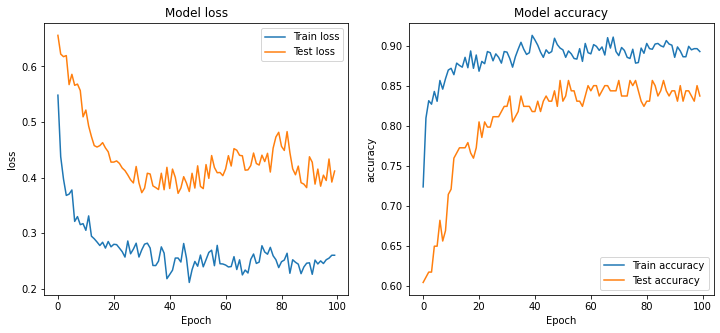

In [ ]:
plot_prediction(100, model_log)

Por último evaluamos también el modelo obtenido sobre el conjunto de test (el mismo con el que hemos obtenido los resultados de validación):

In [ ]:
model_1_loss, model_1_accuracy, model_1_f1_score = model_1.evaluate(X_test, y_test, verbose=1);

6/6 [==============================] - 1s 66ms/step - loss: 0.4222 - accuracy: 0.8276 - f1_score: 0.8235


### Modelo 2

In [ ]:
model_2 = efficientnet_transfer_model()

In [ ]:
model_2.load_weights(model_1_checkpoint_filepath)

In [ ]:
for layer in model_2.layers[-(20+4):]:
  if isinstance(layer, BatchNormalization):
    continue
  else:
    layer.trainable = True

Compilamos el modelo con la función de pérdida *binary cross-entropy*, la más adecuada para problemas de clasificación binaria, y la optimización y métrica requeridas:

In [ ]:
# Compile
model_2.compile(loss='binary_crossentropy', 
                  optimizer=SGD(learning_rate=0.1/10), 
                  metrics=['accuracy', F1Score(num_classes=1, average='macro', threshold=0.5)])

Entrenamos el modelo con 100 épocas y un *batch size* de 128, tal y como se nos requiere, guardando e imprimiendo además el tiempo de entrenamiento:

In [ ]:
model_2_checkpoint_filepath = path.join(models_dir, 'model_2', date)
model_2_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=model_2_checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Entrenar el modelo
model_2_log = model_2.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=50, 
                    batch_size=128,
                    shuffle=True,
                    verbose=True,
                    callbacks=[model_2_checkpoint_callback])

Epoch 1/50
11/11 [==============================] - 48s 4s/step - loss: 0.6435 - accuracy: 0.8223 - f1_score: 0.8035 - val_loss: 0.5743 - val_accuracy: 0.8312 - val_f1_score: 0.7969
Epoch 2/50
11/11 [==============================] - 2s 179ms/step - loss: 0.3081 - accuracy: 0.8745 - f1_score: 0.8643 - val_loss: 1.0141 - val_accuracy: 0.7597 - val_f1_score: 0.6838
Epoch 3/50
11/11 [==============================] - 2s 166ms/step - loss: 0.3126 - accuracy: 0.8760 - f1_score: 0.8611 - val_loss: 0.5444 - val_accuracy: 0.8052 - val_f1_score: 0.8000
Epoch 4/50
11/11 [==============================] - 37s 4s/step - loss: 0.2578 - accuracy: 0.8941 - f1_score: 0.8823 - val_loss: 0.4358 - val_accuracy: 0.8571 - val_f1_score: 0.8472
Epoch 5/50
11/11 [==============================] - 2s 167ms/step - loss: 0.2028 - accuracy: 0.9144 - f1_score: 0.9063 - val_loss: 0.4916 - val_accuracy: 0.8117 - val_f1_score: 0.8242
Epoch 6/50
11/11 [==============================] - 2s 166ms/step - loss: 0.1918 - a

In [ ]:
model_2.load_weights(model_2_checkpoint_filepath)

Las gráficas de *loss* y *accuracy* para la red neuronal artificial son las siguietes:

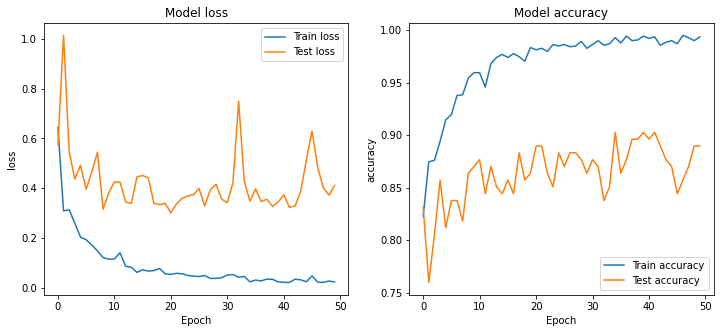

In [ ]:
plot_prediction(100, model_2_log)

Por último evaluamos también el modelo obtenido sobre el conjunto de test (el mismo con el que hemos obtenido los resultados de validación):

In [ ]:
model_2_loss, model_2_accuracy, model_2_f1_score = model_2.evaluate(X_test, y_test, verbose=1);

6/6 [==============================] - 0s 38ms/step - loss: 0.3686 - accuracy: 0.8966 - f1_score: 0.8989


### Modelo 3

In [ ]:
model_3 = efficientnet_transfer_model()

In [ ]:
model_3.load_weights(model_2_checkpoint_filepath)

In [ ]:
for layer in model_3.layers:
  if isinstance(layer, BatchNormalization):
    continue
  else:
    layer.trainable = True

Compilamos el modelo con la función de pérdida *binary cross-entropy*, la más adecuada para problemas de clasificación binaria, y la optimización y métrica requeridas:

In [ ]:
# Compile
model_3.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=1e-10), 
                  metrics=['accuracy', F1Score(num_classes=1, average='macro', threshold=0.5)])

Entrenamos el modelo con 100 épocas y un *batch size* de 128, tal y como se nos requiere, guardando e imprimiendo además el tiempo de entrenamiento:

In [ ]:
model_3_checkpoint_filepath = path.join(models_dir, 'model_3', date)
model_3_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=model_3_checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# Entrenar el modelo
model_3_log = model_3.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=10, 
                    batch_size=128//6,
                    shuffle=True,
                    verbose=True,
                    callbacks=[model_3_checkpoint_callback])

Epoch 1/10
66/66 [==============================] - 61s 738ms/step - loss: nan - accuracy: 0.5533 - f1_score: 0.0284 - val_loss: nan - val_accuracy: 0.5390 - val_f1_score: 0.0000e+00
Epoch 2/10
66/66 [==============================] - 11s 170ms/step - loss: nan - accuracy: 0.5468 - f1_score: 0.0000e+00 - val_loss: nan - val_accuracy: 0.5390 - val_f1_score: 0.0000e+00
Epoch 3/10
66/66 [==============================] - 11s 169ms/step - loss: nan - accuracy: 0.5468 - f1_score: 0.0000e+00 - val_loss: nan - val_accuracy: 0.5390 - val_f1_score: 0.0000e+00
Epoch 4/10
66/66 [==============================] - 11s 170ms/step - loss: nan - accuracy: 0.5468 - f1_score: 0.0000e+00 - val_loss: nan - val_accuracy: 0.5390 - val_f1_score: 0.0000e+00
Epoch 5/10
66/66 [==============================] - 11s 168ms/step - loss: nan - accuracy: 0.5468 - f1_score: 0.0000e+00 - val_loss: nan - val_accuracy: 0.5390 - val_f1_score: 0.0000e+00
Epoch 6/10
66/66 [==============================] - 11s 170ms/step - 

In [ ]:
model_3.load_weights(model_3_checkpoint_filepath)

Las gráficas de *loss* y *accuracy* para la red neuronal artificial son las siguietes:

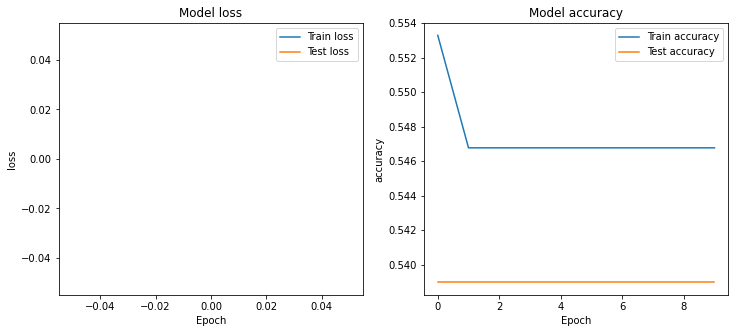

In [ ]:
plot_prediction(100, model_3_log)

Por último evaluamos también el modelo obtenido sobre el conjunto de test (el mismo con el que hemos obtenido los resultados de validación):

In [ ]:
model_3_loss, model_3_accuracy, model_3_f1_score = model_3.evaluate(X_test, y_test, verbose=1);

6/6 [==============================] - 0s 39ms/step - loss: nan - accuracy: 0.4713 - f1_score: 0.0000e+00


## 5. Comparativa de los modelos implementados y predicción [1,5 puntos]

En este último apartado compararemos los modelos implementados y realizaremos la clasificación de algunas imágenes con el modelo que ha dado los mejores resultados.

### 5.1 Comparativa de los modelos implementados

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [0,5 pts.]:</strong> Realizar una comparativa de los modelos implementados comentando:

*   La precisión obtenida
*   La pérdida
*   El tiempo de entrenamiento
*   El número de parámetros a entrenar

Comentar los resultados obtenidos.

En base a los resultados obtenidos ¿Qué modelo seleccionaríais como el mejor?
</div>

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Solución:</strong> 
</div>

Agrupamos todos los resultados obtenidos (*accuracy, loss*, tiempo de entrenamiento y número de parámetros) en una *dataframe*, para que así se muestren como tabla. Formateamos también el tiempo de entrenamiento para mostrarlo en horas, minutos y segundos. 

Los resultados obtenidos son los siguientes:

In [ ]:
import pandas as pd
import datetime

In [ ]:
def format_training_time(x):
  return str(datetime.timedelta(seconds=round(x)))

In [ ]:
pd.DataFrame({
    'accuracy': [ann_accuracy, shallow_cnn_accuracy, deep_cnn_accuracy, deep_c_cnn_accuracy],
    'loss': [ann_loss, shallow_cnn_loss, deep_cnn_loss, deep_c_cnn_loss],
    'training_time': list(map(format_training_time, [ann_training_time, shallow_cnn_training_time, deep_cnn_training_time, deep_c_cnn_training_time])),
    'training_parameters': [ann_trainable_parameters, shallow_cnn_trainable_parameters, deep_cnn_trainable_parameters, deep_c_cnn_trainable_parameters]
}, index = ['ANN', 'Shallow CNN', 'Deep CNN', 'Deep Colorful CNN'])

,accuracy,loss,training_time,training_parameters
ANN,0.4399,1.581292,0:04:24,215050
Shallow CNN,0.5820,1.304926,0:01:33,576650
Deep CNN,0.7841,0.707106,0:32:52,549994
Deep Colorful CNN,0.8096,0.621048,0:34:24,550570


Observando la combinación de *accuracy* y tiempo de entrenamiento queda claro que el peor modelo es la red neuronal artificial, dado que la *accuracy* que obtiene es muy baja y el tiempo de entrenamiento es superior al de la red convolucional monocapa, que ha necesitado menos épocas para obtener una *accuracy* superior. 

De la red convolucional monocapa a las dos profundas hay un claro salto tanto en el tiempo de entrenamiento como en la *accuracy* obtenida. Siendo este el caso, y teniendo en cuenta que el tiempo de entrenamiento de las redes convolucionales profundas no es extremadamente elevado, la elección más clara es la red profunda que usa todos los colores, `Deep Colourful CNN`.

### 5.2 Análisis de la mejor solución

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [0,5 pts.]:</strong> Realizar un análisis de las medidas estadísticas más relevantes del modelo seleccionado en el apartado anterior y representar su matriz de confusión.

¿Qué clase es la que mejor se predice? ¿Y la que peor resultados obtiene?

Comentar los resultados
</div>

In [ ]:
pred = deep_c_cnn.predict(X_test_normalized)

Utilizamos la función `classification_report()` de `sklearn` para realizar el análisis de las medidas más relevantes del mejor modelo obtenido:

In [ ]:
# Informe
print(classification_report(y_true=y_test, y_pred=pred.argmax(axis=1), target_names=labels_dict.values()))

              precision    recall  f1-score   support

    airplane       0.82      0.85      0.84      1000
  automobile       0.91      0.90      0.91      1000
        bird       0.81      0.68      0.74      1000
         cat       0.66      0.62      0.64      1000
        deer       0.73      0.82      0.77      1000
         dog       0.74      0.68      0.71      1000
        frog       0.82      0.88      0.85      1000
       horse       0.84      0.87      0.86      1000
        ship       0.88      0.91      0.89      1000
       truck       0.89      0.87      0.88      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



Como podemos ver las tres categorias donde más acierta el modelo al clasificar una imagen como tal (medida por la *precision*) son coches, camiones, y barcos. En el extremo contrario tenemos a la clase de gatos, en la cual muchas imágenes son clasificadas de manera errónea. 

La clase de gatos es también aquella con menor proporción de imágenes detectadas como tal (medido por el *recall*), seguida por pájaros y perros. 
En el otro extremo tenemos de nuevo a barcos y coches, siendo los camiones un poco más dificiles de identificar.

Combinando ámbos criterios, las clases en las que el modelo obtiene mejores resultados son barcos, coches y camiones. La clase en la que obtiene peores resultados es la de gatos. 

A continuación mostramos la matriz de confusión obtenida por el mejor modelo sobre el conjunto de evaluación:

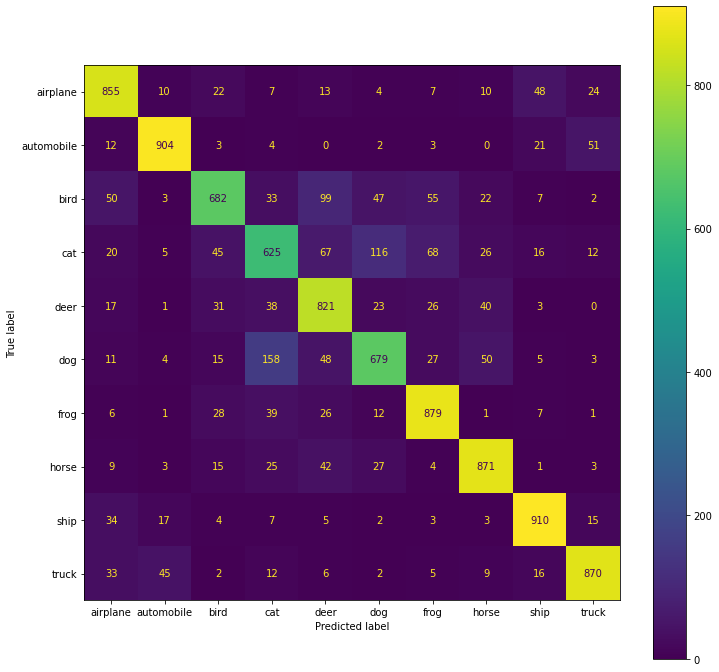

In [ ]:
# Matriz de confusión
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(12, 12)) # Para hacer más grande la matriz
ConfusionMatrixDisplay.from_predictions(y_true=y_test,
                                        y_pred=pred.argmax(axis=1), 
                                        display_labels=labels_dict.values(),
                                        ax=ax);

Lo más remarcable es lo visible que es la división entre animales y vehículos, grupos dentro de los cuales el modelo comete muchos errores, pero que raramente distingue entre si. 

Por ejemplo, los gatos, categoría con menos Verdaderos Positivos, son frecuentemente confundidos por el modelo con perros, ciervos y ranas, pero mucho menos coches, barcos y camiones. 
De la misma manera, los aviones suele confundirlos con barcos y camiones, pero casi nunca con ranas, perros o gatos. 

De entre estos dos grupos el más problemático es el de los animales, donde perros y gatos son confundidos entre si, los pájaros son confundidos con ciervos y ranas, etcétera. 

### 5.3 Predicción de algunas imágenes del conjunto de test

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [0,5 pts.]:</strong> Visualizar diez imágenes al azar del conjunto de test. Mostrar la etiqueta real y la predicción.
</div>

A continuación mostramos 10 imágenes al azar del conjunto de test:

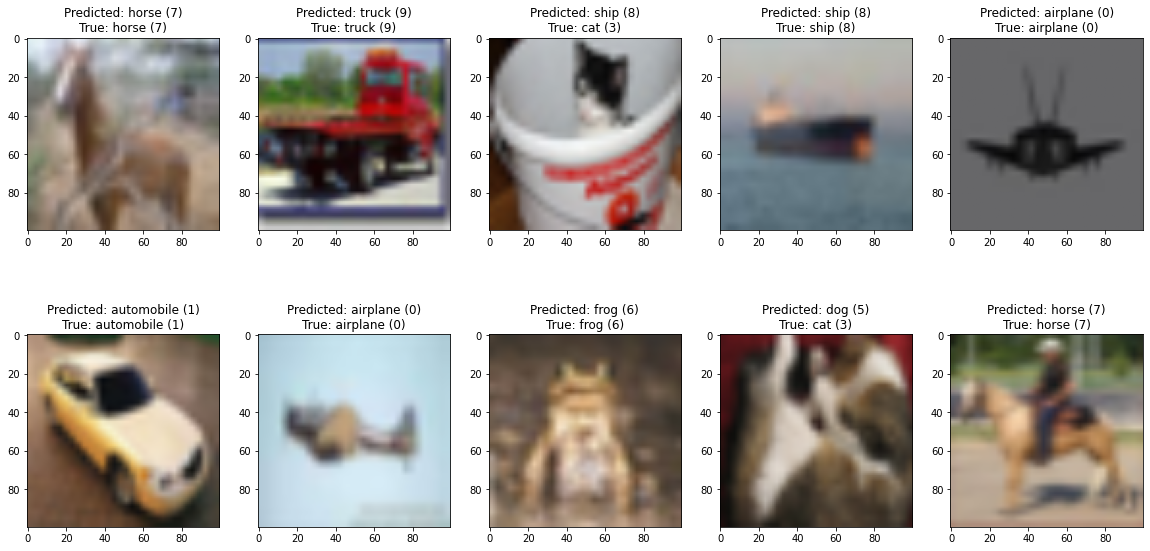

In [ ]:
# Visualización
image, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 10))
random_indexes = np.random.choice(X_test_normalized.shape[0], 10, replace=False)  
X_test_normalized_sample = X_test_normalized[random_indexes]
y_test_sample = y_test[random_indexes]
y_preds = deep_c_cnn.predict(X_test_normalized_sample).argmax(axis=1)
for i, ax in enumerate(axes.flat):
  image = X_test_normalized_sample[i]
  image = tf.image.resize(image, (100,100)).numpy()
  ax.imshow(image)
  y_true = y_test_sample[i][0]
  y_pred = y_preds[i]
  ax.set_title(f"Predicted: {labels_dict[y_pred]} ({y_pred})\nTrue: {labels_dict[y_true]} ({y_true})")
plt.show()

Aunque el modelo comete algunos errores claros, también es cierto que algunas imágenes son dificiles de clasificar para el ojo humano, debido a la poca calidad de las imágenes.